# Covariance of the shots count
Let us explore the covariance of the shots count
for different strings. We will repeat string search
`experiments_count` times and save the shots count for
each string and experiment in `experiments_shots_count`.
Let's run the experiment 100 times:

In [4]:
experiments_count = 100
from string_comparison import StringComparator
experiments_shots_count = []
dataset = ['01001', '11010', '01110', '10110']
x = StringComparator('10110', dataset, symbol_length=1)
for _ in range (experiments_count):
    results = x.run()
    experiment_shots_count = []
    for p_val in results['p_values']:
        # reconstruct shots count from the p-values
        experiment_shots_count.append(
            p_val * results['prob_of_measuring_register_c_as_0'] * results['useful_shots_count'])

    experiments_shots_count.append(experiment_shots_count)

# Convert shots stats to Pandas DataFrame
import pandas as pd
experiments_shots_count = pd.DataFrame(experiments_shots_count)
experiments_shots_count.columns = dataset
experiments_shots_count

,01001,11010,01110,10110
0,0.0,1274.0,1320.0,2030.0
1,0.0,1335.0,1259.0,2050.0
2,0.0,1408.0,1302.0,2027.0
3,0.0,1379.0,1298.0,2076.0
4,0.0,1373.0,1314.0,2069.0
...,...,...,...,...
95,0.0,1372.0,1314.0,2009.0
96,0.0,1324.0,1368.0,2092.0
97,0.0,1346.0,1361.0,1999.0
98,0.0,1366.0,1300.0,2057.0


Now let us compute the covariance matrix:

In [5]:
cov_shots = pd.DataFrame.cov(experiments_shots_count)
cov_shots

,01001,11010,01110,10110
01001,0.0,0.000000,0.000000,0.000000
11010,0.0,947.483939,-235.188788,-272.677677
01110,0.0,-235.188788,1087.774848,-328.360505
10110,0.0,-272.677677,-328.360505,1570.393030


And visualize the covariance matrix:


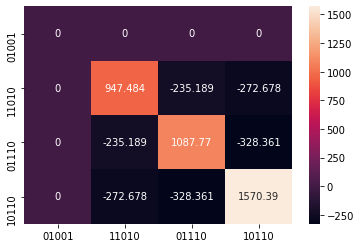

In [6]:
import seaborn
import matplotlib.pyplot as plt
seaborn.heatmap(cov_shots, annot=True, fmt='g')
plt.show()

The empirical covariance matrix suggests that individual variables are correlated.
The non-diagonal terms are a magnitude smaller than the diagonal ones, but I am not certain if we
can discard them. Let's compare the variance with and without the non-diagonal terms:

First, let's assume that the variables are uncorrelated and that the non-diagonal terms
can be discarded:

In [7]:
cov_shots.values.diagonal().sum()

3605.651818181819

Now, let's assume that the variables are correlated and that the non-diagonal terms
are retained:

In [8]:
cov_shots.values.sum()

1933.1978787878788

As we can see, it is in our best interest to retain the complete covariance matrix,
as it helps to reduce the overall variance by a factor of two.

Thus, in this case the variance is


In [9]:
1 / pow(results['useful_shots_count'], 2) * cov_shots.values.sum()

2.8806893211422545e-05

which would give a tight interval around the `prob_of_measuring_register_c_as_0`.


# Effect of shots count on the p-values
## Small database
In the above example we use 8192 shots to compute the variance for a database of four strings.
Can we go lower than that? Let us now explore how the p-values change with the number of shots.

In [10]:
# number of repetitions
experiments_count = 100

experiments_p_val = []
dataset = ['01001', '11010', '01110', '10110']

for shots_count in range(1, 1001, 100):
    if shots_count > 1:
        shots_count -= 1  # To have nice round numbers
    x = StringComparator('10110', dataset, symbol_length=1, shots=shots_count)
    for _ in range (experiments_count):
        results = x.run()
        experiments_p_val.append([shots_count, results['prob_of_measuring_register_c_as_0']])

experiments_p_val = pd.DataFrame(experiments_p_val)
experiments_p_val.columns = ['shots_count', 'prob_of_measuring_register_c_as_0']
experiments_p_val

,shots_count,prob_of_measuring_register_c_as_0
0,1,0.000000
1,1,1.000000
2,1,0.000000
3,1,1.000000
4,1,1.000000
...,...,...
995,900,0.571111
996,900,0.595556
997,900,0.573333
998,900,0.585556


And the summary stats look as follows

In [11]:
experiments_p_val.groupby(['shots_count'])['prob_of_measuring_register_c_as_0'].agg(['mean', 'var'])

,mean,var
shots_count,,
1,0.690000,0.216061
100,0.565800,0.002560
200,0.575700,0.001137
300,0.575300,0.000718
400,0.577175,0.000764
500,0.578100,0.000642
600,0.576767,0.000269
700,0.577686,0.000341
800,0.574200,0.000342


As expected, the variance of the results reduces as we increase the number of shots count.

What is the theoretical value of `prob_of_measuring_register_c_as_0`?
We know that
\begin{equation}
\alpha_k = \frac{N}{r} \cos^2{\left[\frac{\pi}{2z}  D\left(t,p^k\right)\right]}.
\end{equation}
In our toy example, the values of $D\left(t,p^k\right)$ are 0, 2, 2, and 5. Thus, the $\alpha$ values are:

In [12]:
import numpy as np
distances = [5, 2, 2, 0]
alphas = []
theor_shots = 100000.0
string_count = len(distances) # let's use some high number
string_length = 5
for d in distances:
    alphas.append(
        theor_shots / string_count * pow(np.cos(np.pi / (2 * string_length) * d), 2)
    )
alphas

[9.37349864163661e-29, 16362.712429686842, 16362.712429686842, 25000.0]

Given that
\begin{equation}
c = \frac{\sum_{j=1}^{r}{\alpha_j}}{N},
\end{equation}
an expected value of `prob_of_measuring_register_c_as_0` is

In [13]:
expected_prob_of_measuring_register_c_as_0 = np.array(alphas).sum() / theor_shots
expected_prob_of_measuring_register_c_as_0

0.5772542485937369

Now let's visualize the results. Red dotted line represents the expected value.

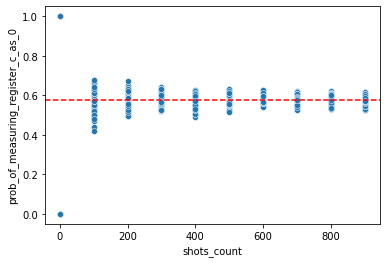

In [14]:
my_plot = seaborn.scatterplot(data=experiments_p_val,
                              x='shots_count',
                              y='prob_of_measuring_register_c_as_0')
my_plot.axhline(expected_prob_of_measuring_register_c_as_0,
                color='r', linestyle = '--')
plt.show()


The above scatter plot makes it difficult to see distribution of values for the specific value of `shots_count`.
Let's use box-and-whiskers instead.


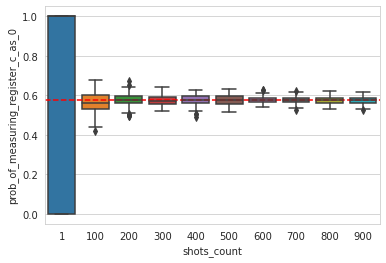

In [15]:
seaborn.set_style("whitegrid")
my_plot = seaborn.boxplot(data=experiments_p_val,
                              x='shots_count',
                              y='prob_of_measuring_register_c_as_0')
my_plot.axhline(expected_prob_of_measuring_register_c_as_0,
                color='r', linestyle = '--')
plt.show()

Note that past 300 shots the variance decreases slowly. Let's filter out `shots_count == 1` to zoom in:

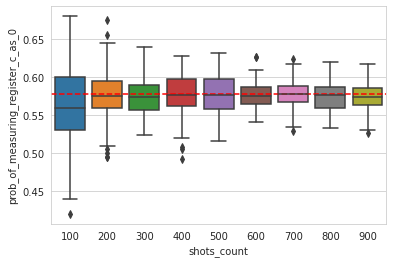

In [16]:
seaborn.set_style("whitegrid")
my_plot = seaborn.boxplot(data=experiments_p_val[experiments_p_val['shots_count'] > 1],
                              x='shots_count',
                              y='prob_of_measuring_register_c_as_0')
my_plot.axhline(expected_prob_of_measuring_register_c_as_0,
                color='r', linestyle = '--')
plt.show()

## Medium database
### Values closer to 1.0
Let's repeat this exercise, but increase the database size.

Let's create a database of 100 strings, 12 bits long. Most of the strings will have $D < 5$.

In [17]:
import random
random.seed(12345)  # for reproducibility
target_string = '101010101010'
# populate database
max_string_count = 100
# add four strings with D = 0, 1, 11, 12
medium_dataset = {'101010101010',  # D = 0
                  '101110101010',  # D = 1
                  '011101010101',  # D = 11
                  '010101010101'}  # D = 12

# now let's generate strings with D between 8 and 10
dictionary = '01'
while len(medium_dataset) < max_string_count:
    db_string = ''.join(random.choice(dictionary) for i in range(len(target_string)))
    hd = StringComparator.hamming_distance(target_string, db_string)
    if hd < 5 and db_string not in medium_dataset:
        medium_dataset.add(db_string)
medium_dataset = list(medium_dataset)
pd.DataFrame(medium_dataset)

,0
0,110010011010
1,100110001011
2,100111101000
3,100011101011
4,100110111000
...,...
95,101010010010
96,011101010101
97,101101101110
98,101111111000


Let's compute expected value of $c$ (`prob_of_measuring_register_c_as_0`):


In [18]:
alphas = []
theor_shots = 10000000.0
string_count = len(medium_dataset) # let's use some high number
string_length = len(target_string)
for my_str in medium_dataset:
    d = StringComparator.hamming_distance(target_string, my_str)
    alphas.append(
        theor_shots / string_count * pow(np.cos(np.pi / (2 * string_length) * d), 2)
    )
expected_prob_of_measuring_register_c_as_0 = np.array(alphas).sum() / theor_shots
expected_prob_of_measuring_register_c_as_0


0.7852251517434731

Now let's get the empirical values of `prob_of_measuring_register_c_as_0`:


In [19]:
# number of repetitions
experiments_count = 100

med_db_experiments_p_val = []
for shots_count in range(1, 1001, 100):
    if shots_count > 1:
        shots_count -= 1  # To have nice round numbers
    x = StringComparator(target_string, medium_dataset, symbol_length=1, shots=shots_count)
    for _ in range (experiments_count):
        results = x.run()
        med_db_experiments_p_val.append([shots_count, results['prob_of_measuring_register_c_as_0']])

med_db_experiments_p_val = pd.DataFrame(med_db_experiments_p_val)
med_db_experiments_p_val.columns = ['shots_count', 'prob_of_measuring_register_c_as_0']
med_db_experiments_p_val


,shots_count,prob_of_measuring_register_c_as_0
0,1,1.000000
1,1,1.000000
2,1,0.000000
3,1,1.000000
4,1,0.000000
...,...,...
995,900,0.771111
996,900,0.795556
997,900,0.811111
998,900,0.795556


Let's compare distributions of the empirical `prob_of_measuring_register_c_as_0` and it's expected value:

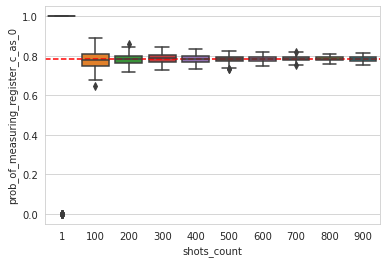

In [20]:
seaborn.set_style("whitegrid")
my_plot = seaborn.boxplot(data=med_db_experiments_p_val,
                              x='shots_count',
                              y='prob_of_measuring_register_c_as_0')
my_plot.axhline(expected_prob_of_measuring_register_c_as_0,
                color='r', linestyle = '--')
plt.show()


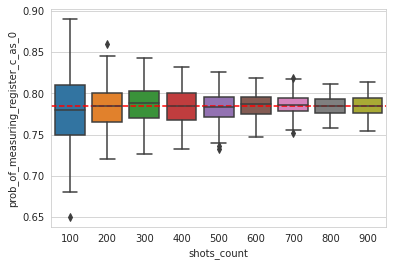

In [21]:

seaborn.set_style("whitegrid")
my_plot = seaborn.boxplot(data=med_db_experiments_p_val[med_db_experiments_p_val['shots_count']>1],
                              x='shots_count',
                              y='prob_of_measuring_register_c_as_0')
my_plot.axhline(expected_prob_of_measuring_register_c_as_0,
                color='r', linestyle = '--')
plt.show()

Let's also check the numeric values of variance:

In [22]:
med_db_experiments_p_val.groupby(['shots_count'])['prob_of_measuring_register_c_as_0'].agg(['mean', 'var'])

,mean,var
shots_count,,
1,0.770000,0.178889
100,0.781500,0.001900
200,0.783250,0.000747
300,0.786167,0.000574
400,0.784725,0.000461
500,0.782440,0.000364
600,0.785433,0.000231
700,0.786114,0.000233
800,0.785062,0.000173


As we can see, the variance here decreases consistently with the increase of the numebr of shots. This may imply that it is easire to compute `prob_of_measuring_register_c_as_0` if it is far enough from 0.5. 
Let's test this hypothesis by creating a dataset with expected value closer to 0.5. Before we do, let's see if theoretical values of the dataset coinside with the actual ones by naively drawing from bernoulli distribution wih p-value of drawing 1 set to `expected_prob_of_measuring_register_c_as_0`.

In [23]:
from scipy.stats import bernoulli
# number of repetitions
experiments_count = 100

theor_med_db_experiments_p_val = []
for shots_count in range(1, 1001, 100):
    if shots_count > 1:
        shots_count -= 1  # To have nice round numbers
    for _ in range (experiments_count):
            theor_med_db_experiments_p_val.append([shots_count, int(bernoulli.rvs(p=expected_prob_of_measuring_register_c_as_0, size=1))])

theor_med_db_experiments_p_val = pd.DataFrame(theor_med_db_experiments_p_val)
theor_med_db_experiments_p_val.columns = ['shots_count', 'prob_of_measuring_register_c_as_0']
theor_med_db_experiments_p_val

,shots_count,prob_of_measuring_register_c_as_0
0,1,1
1,1,1
2,1,1
3,1,0
4,1,0
...,...,...
995,900,1
996,900,0
997,900,0
998,900,1


In [24]:
theor_med_db_experiments_p_val.groupby(['shots_count'])['prob_of_measuring_register_c_as_0'].agg(['mean', 'var'])

,mean,var
shots_count,,
1,0.78,0.173333
100,0.73,0.199091
200,0.78,0.173333
300,0.81,0.155455
400,0.77,0.178889
500,0.89,0.098889
600,0.84,0.135758
700,0.83,0.142525
800,0.92,0.074343


It seems that naive draw from the Bernoulli distribution does not give as good result as the actual experiment. Perhaps we need to make it more realistic and draw specific string first (based on the values of `alphas`)?

### Values closer to 0.5
Let's fill the database with the majority of strings with $D=6$.

In [25]:
import random
from string_comparison import StringComparator
random.seed(12345)  # for reproducibility
target_string = '101010101010'
# populate database
max_string_count = 100
# add four strings with D = 0, 1, 11, 12
medium_dataset_far = {'101010101010',  # D = 0
                  '101110101010',  # D = 1
                  '011101010101',  # D = 11
                  '010101010101'}  # D = 12

# now let's generate strings with D between 8 and 10
dictionary = '01'
while len(medium_dataset_far) < max_string_count:
    db_string = ''.join(random.choice(dictionary) for i in range(len(target_string)))
    hd = StringComparator.hamming_distance(target_string, db_string)
    if hd == 6 and db_string not in medium_dataset_far:
        medium_dataset_far.add(db_string)
medium_dataset_far = list(medium_dataset_far)
pd.DataFrame(medium_dataset_far)

,0
0,001010010111
1,100111000000
2,011011010010
3,001100111100
4,000001001110
...,...
95,110110110110
96,011101010101
97,011101101000
98,011001110010


The theoretical value of `prob_of_measuring_register_c_as_0` is exactly 0.5:

In [26]:
alphas = []
theor_shots = 10000000.0
string_count = len(medium_dataset_far) # let's use some high number
string_length = len(target_string)
for my_str in medium_dataset_far:
    d = StringComparator.hamming_distance(target_string, my_str)
    alphas.append(
        theor_shots / string_count * pow(np.cos(np.pi / (2 * string_length) * d), 2)
    )
expected_prob_of_measuring_register_c_as_0 = np.array(alphas).sum() / theor_shots
expected_prob_of_measuring_register_c_as_0

0.5000000000000001

And the empirical values of `prob_of_measuring_register_c_as_0` are 

In [27]:
# number of repetitions
experiments_count = 100
from string_comparison import StringComparator
med_db_experiments_p_val_far = []
for shots_count in range(1, 1001, 100):
    if shots_count > 1:
        shots_count -= 1  # To have nice round numbers
    x = StringComparator(target_string, medium_dataset_far, symbol_length=1, shots=shots_count)
    for _ in range (experiments_count):
        results = x.run()
        med_db_experiments_p_val_far.append([shots_count, results['prob_of_measuring_register_c_as_0']])

med_db_experiments_p_val_far = pd.DataFrame(med_db_experiments_p_val_far)
med_db_experiments_p_val_far.columns = ['shots_count', 'prob_of_measuring_register_c_as_0']
med_db_experiments_p_val_far

,shots_count,prob_of_measuring_register_c_as_0
0,1,1.000000
1,1,1.000000
2,1,1.000000
3,1,1.000000
4,1,0.000000
...,...,...
995,900,0.484444
996,900,0.500000
997,900,0.514444
998,900,0.486667


The results are as follows:

In [28]:
med_db_experiments_p_val_far.groupby(['shots_count'])['prob_of_measuring_register_c_as_0'].agg(['mean', 'var'])

,mean,var
shots_count,,
1,0.490000,0.252424
100,0.498600,0.002697
200,0.504900,0.001494
300,0.497900,0.000807
400,0.496175,0.000657
500,0.498800,0.000564
600,0.496167,0.000398
700,0.500157,0.000288
800,0.500500,0.000342


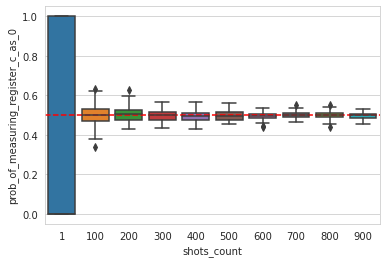

In [29]:
seaborn.set_style("whitegrid")
my_plot = seaborn.boxplot(data=med_db_experiments_p_val_far,
                              x='shots_count',
                              y='prob_of_measuring_register_c_as_0')
my_plot.axhline(expected_prob_of_measuring_register_c_as_0,
                color='r', linestyle = '--')
plt.show()

And w/o the value of 1:

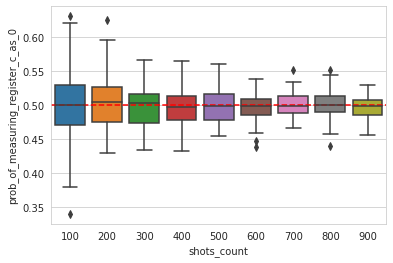

In [30]:
seaborn.set_style("whitegrid")
my_plot = seaborn.boxplot(data=med_db_experiments_p_val_far[med_db_experiments_p_val_far['shots_count']>1],
                              x='shots_count',
                              y='prob_of_measuring_register_c_as_0')
my_plot.axhline(expected_prob_of_measuring_register_c_as_0,
                color='r', linestyle = '--')
plt.show()